In [59]:
import torch
import torchvision
import os, time, tqdm
from models.cvae2 import loss, cVAE
from utils import EarlyStop
from datasets import celeba
from matplotlib import pyplot as plt
from datasets.inpainting import DeleteRandomRectangle, DeleteRectangle

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [61]:
def crop(x, low, high):
    x[x <= low] = low
    x[x >= high] = high
    return x

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: crop(x, 0., 1.)),
    torchvision.transforms.Resize((109, 89), antialias=True),  # (3, 218, 178) -> (3, 109, 89)
    torchvision.transforms.CenterCrop((64, 64)),
])

train_data = celeba.CelebA(root='C:/Datasets/', download=False, transform=transform)


In [62]:
baseline = cVAE((3, 64, 64), 2, nhid=512, ncond=16)
checkpoint = torch.load("./models/weights/cVAE.pt", map_location=device)
baseline.load_state_dict(checkpoint["net"])
baseline.to(device)
baseline.eval()

cVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2))
      (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): Flatten()
    )
    (calc_mean): MLP(
      (mlp): Sequential(
        (Linear_0): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (calc_logvar): MLP(
      (mlp): Sequential

In [63]:
fineTuned = cVAE((3, 64, 64), 2, nhid=512, ncond=16)
checkpoint = torch.load("./models/weights/cVAE2_finetuned-epoch15.pt", map_location=device)
fineTuned.load_state_dict(checkpoint["net"])
fineTuned.to(device)
fineTuned.eval()

cVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2))
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2))
      (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): Flatten()
    )
    (calc_mean): MLP(
      (mlp): Sequential(
        (Linear_0): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (calc_logvar): MLP(
      (mlp): Sequential

In [64]:
def display_reconstruction(generator, img_index, label, deletion):
    img, _ = train_data[img_index]

    plt.subplot(1, 4, 1)
    plt.imshow(img.squeeze().permute(1,2,0))

    cropped, mask = deletion(img.unsqueeze(0))
    plt.subplot(1, 4, 2)
    plt.imshow(cropped.squeeze().permute(1,2,0))
    
    generated, _, _ = generator(cropped.to(device), torch.tensor([label], device=device))
    generated = generated.cpu().detach()
    plt.subplot(1, 4, 3)
    plt.imshow(generated.squeeze().permute(1,2,0))
    
    result = img * (1 - mask) + generated * mask
    plt.subplot(1, 4, 4)
    plt.imshow(result.cpu().detach().squeeze().permute(1,2,0))
    
    plt.show()

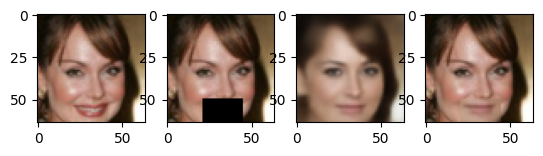

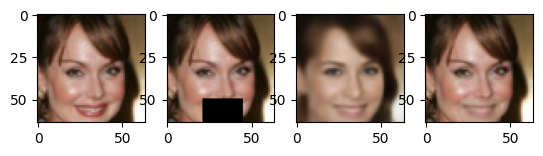

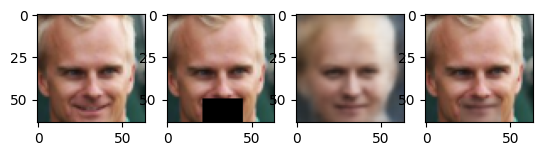

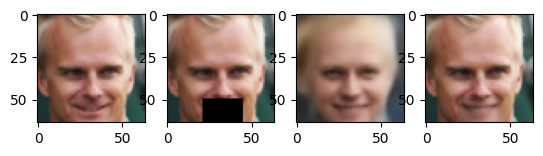

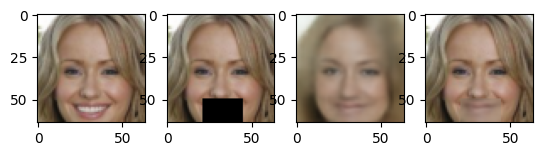

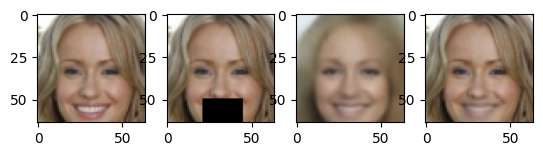

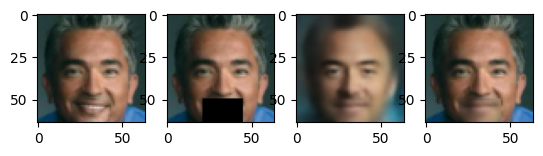

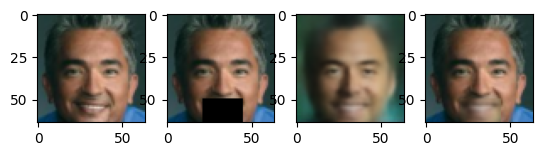

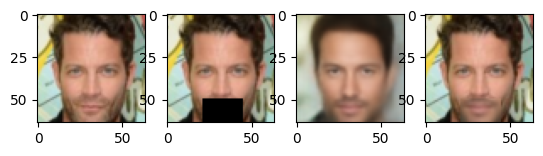

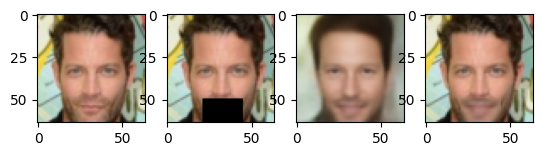

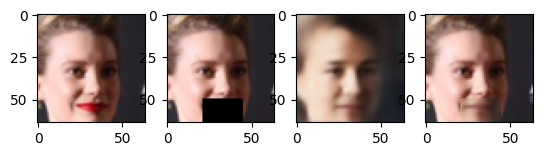

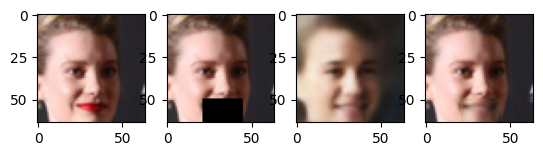

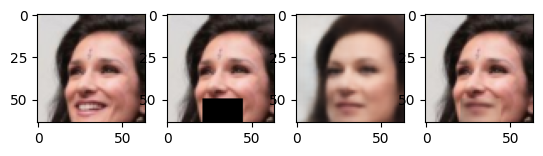

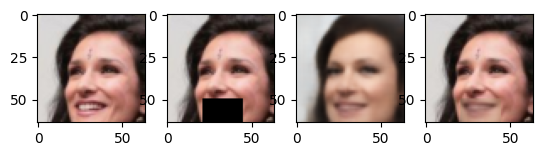

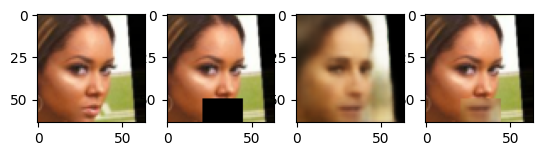

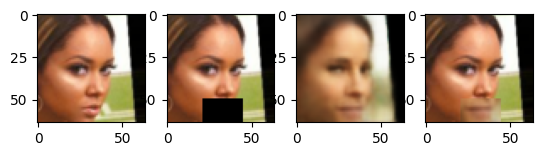

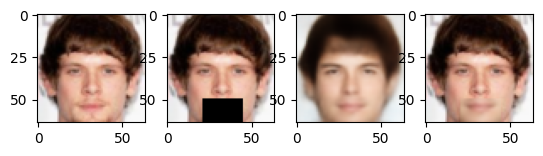

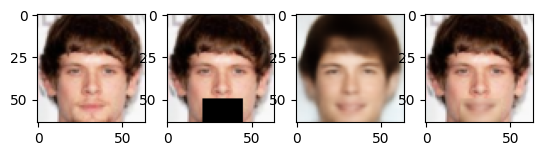

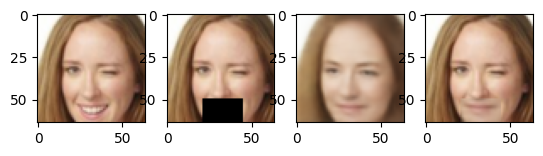

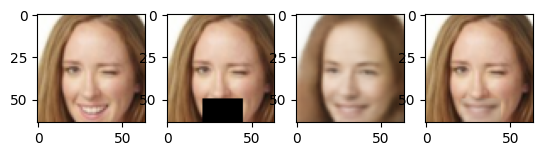

In [65]:
for img_index in [8,12,53,1256,1212,99,231,613,71316,131313]:

    #img_index = 8
    #label = 1

    x1 = 50
    y1 = 21
    x2 = 65
    y2 = 45
    deletion = DeleteRectangle(x1,y1,x2-x1,y2-y1)
    #deletion = DeleteRandomRectangle()

    display_reconstruction(baseline, img_index, 0, deletion)
    display_reconstruction(baseline, img_index, 1, deletion)
    #display_reconstruction(fineTuned, img_index, label, deletion)

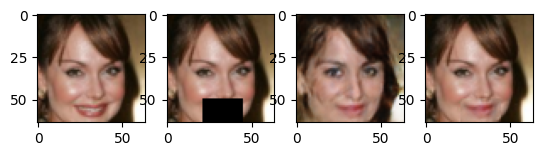

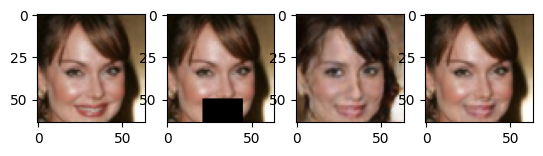

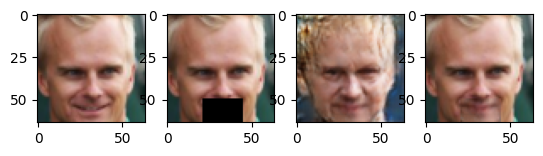

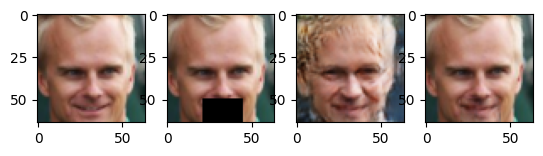

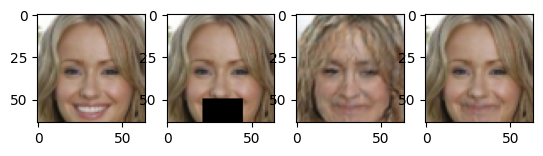

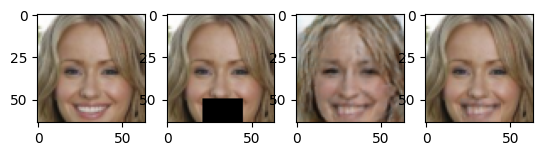

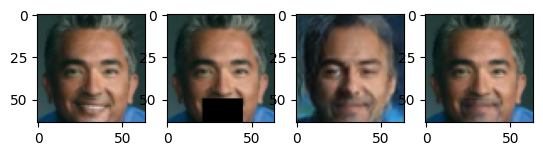

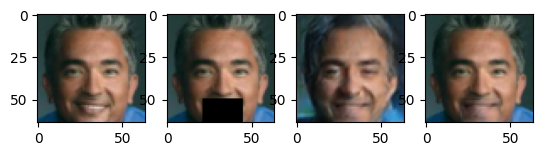

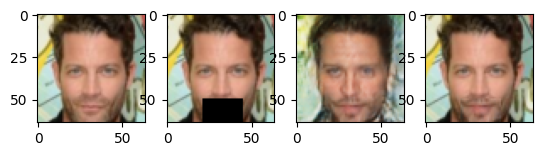

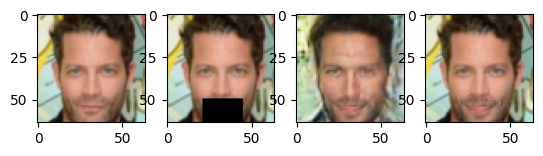

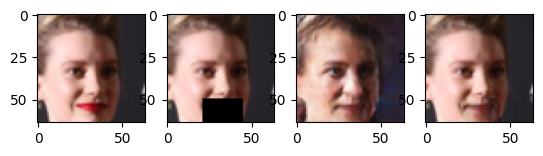

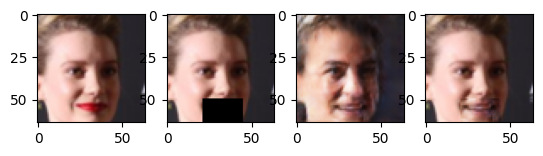

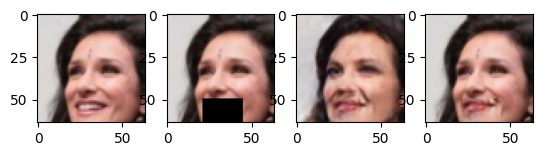

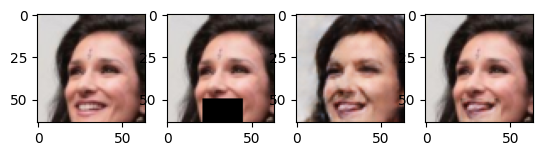

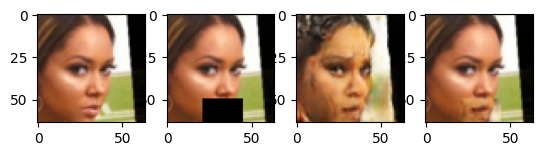

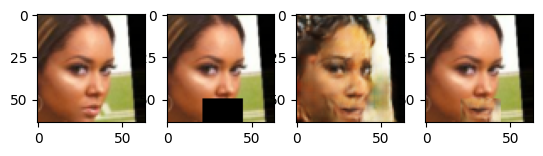

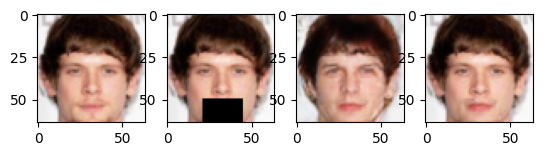

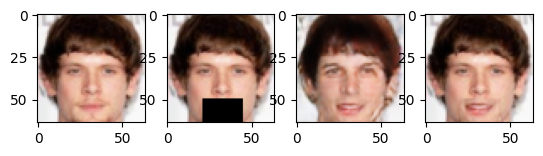

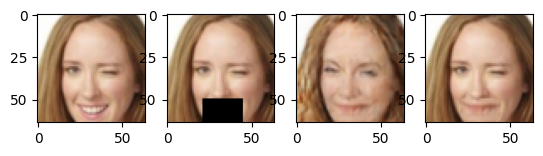

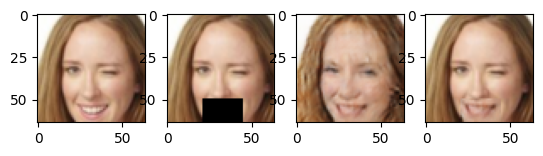

In [66]:
for img_index in [8,12,53,1256,1212,99,231,613,71316,131313]:

    #img_index = 8
    #label = 1

    x1 = 50
    y1 = 21
    x2 = 65
    y2 = 45
    deletion = DeleteRectangle(x1,y1,x2-x1,y2-y1)
    #deletion = DeleteRandomRectangle()

    display_reconstruction(fineTuned, img_index, 0, deletion)
    display_reconstruction(fineTuned, img_index, 1, deletion)